In [20]:
import torch
import numpy as np
import torch.nn.functional as F

In [21]:
words = open('names.txt','r').read().splitlines()

In [22]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [23]:
block_size = (
    8  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [104]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
class Embedding:
    def __init__(self,num_embeddings, embedding_dimension):
        self.weight = torch.randn((num_embeddings,embedding_dimension))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B,T,C  = x.shape
        x = x.view(B,T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []
    
class Sequential:
    def __init__(self,layers):
        self.layers = layers
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [105]:
# (1,2) (3,4) (5,6) (7,8) We want to feed neural the characters in batches of 4 so what to do in this case?

In [106]:
torch.manual_seed(42)

In [116]:
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP
model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2),
        Linear(n_embd * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [117]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

      0/ 200000: 3.3118
  10000/ 200000: 1.9695
  20000/ 200000: 1.9386
  30000/ 200000: 2.1554
  40000/ 200000: 2.2510
  50000/ 200000: 2.0359
  60000/ 200000: 1.7300
  70000/ 200000: 1.6460
  80000/ 200000: 1.8397
  90000/ 200000: 1.5651
 100000/ 200000: 1.7818
 110000/ 200000: 2.0263
 120000/ 200000: 1.8690
 130000/ 200000: 1.5049
 140000/ 200000: 2.2103
 150000/ 200000: 1.8940
 160000/ 200000: 2.1542
 170000/ 200000: 1.4941
 180000/ 200000: 2.0535
 190000/ 200000: 1.7560


## Performance Log
original loss (with batch normalization) train 1.84, val = 2.28 indicating overfitting

loss after changing to wavenet 

In [118]:
for layer in model.layers:
    layer.training = False

In [119]:
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.7286622524261475
val 2.246558904647827


In [120]:
for _ in range(20):
    out = []
    context =[0]* 8
    while True:
        logits = model(torch.tensor([context]))
        logprobs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(logprobs,num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix ==0:
            break
    print(''.join(itos[ix] for ix in out))

mikael.
gabba.
kaydianna.
charlese.
oluwateria.
shiam.
pearshaun.
navona.
makanya.
yoseline.
becca.
rafash.
markelyn.
lavien.
ceniocis.
hagan.
mones.
maianna.
aariana.
laylaole.


### Conclusion:
The above nwural network looks good but it squashes all the embeddings of a character in one layer.

Can we do better? -> of course we can create an RNN layer which can take the inputs and the hidden state and create more expressive representation.

We will consider an example of WaveNet -> Something which is used for generating audio waveform and create more expressive neural network

In [51]:
import matplotlib.pyplot as plt

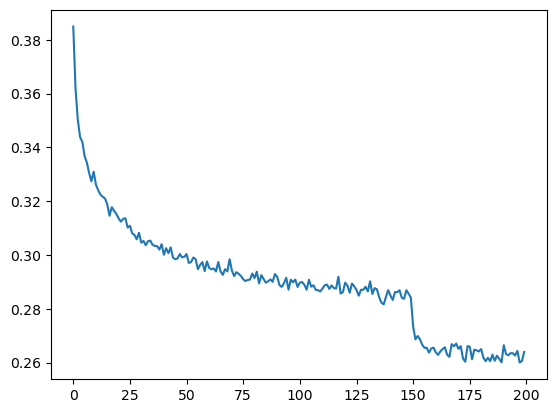

In [52]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

Create a working space to visualize the inner layer of the simple sequential model

In [56]:
ix = torch.randint(0,Xtr.shape[0], (4,)) # Take a batch of 4 samples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)

torch.Size([4, 8])


In [57]:
model.layers[0].out.shape # this is the embedding layer

torch.Size([4, 8, 10])

In [59]:
model.layers[1].out.shape # Flatter layer just takes the 8,10 embedding layer and concatenated them into a single array

torch.Size([4, 80])